In [1]:
%load_ext autoreload
%autoreload 2
    
import mne
import numpy as np
import torch
from subject.braintreebank import BrainTreebankSubject
import os
import sys
import matplotlib 
mne.viz.set_browser_backend('matplotlib')  # safe, 2D-only, no OpenGL

class MNEBraintreebankSubject:
    """
    A subject-specific class to handle BrainTreeBank data and convert it to MNE Raw objects.
    """
    def __init__(self, subject_id: str, allow_corrupted: bool = False, cache: bool = True):
        """
        Initializes the subject, loads non-trial-specific data like channel names and montage.

        Parameters:
        - subject_id: The identifier for the subject (e.g., 'P001S01').
        - allow_corrupted: Whether to include electrodes marked as corrupted.
        - cache: Whether to cache neural data in memory for faster access.
        """
        self.subject = BrainTreebankSubject(
            subject_id=subject_id,
            allow_corrupted=allow_corrupted,
            cache=cache
        )
        
        # Get data that is not trial-specific
        self.ch_names = self.subject.get_electrode_labels()
        self.sfreq = self.subject.get_sampling_rate()
        self.ch_types = ['seeg'] * len(self.ch_names)
        
        # Create MNE Info object that will be shared across trials
        self.info = mne.create_info(ch_names=self.ch_names, sfreq=self.sfreq, ch_types=self.ch_types)
        
        # Get electrode coordinates and set montage
        coords = self.subject.get_electrode_coordinates().numpy()  # in mm, (L, I, P)
        coords_m = coords / 1000.0  # Convert coordinates from mm to meters

        # Convert from LIP to RAS for MNE (x=Right, y=Anterior, z=Superior)
        # R = -L, A = -P, S = -I
        # Our coordinates are L, I, P. So we map:
        # x (Right) = -L -> index 0
        # y (Anterior) = -P -> index 2
        # z (Superior) = -I -> index 1
        ras_coords = np.c_[-coords_m[:, 0], -coords_m[:, 2], -coords_m[:, 1]]
        self.ch_pos = dict(zip(self.ch_names, ras_coords))
        
        self.montage = mne.channels.make_dig_montage(ch_pos=self.ch_pos, coord_frame='head')
        self.info.set_montage(self.montage)

    def get_trial_raw(self, trial_id: int, t_to = None, t_from = None, ref_channels = 'average') -> mne.io.RawArray:
        """
        Loads the electrode data for a specific trial and returns it as an MNE RawArray object.
        Re-references data if ref_channels == 'average'

        Parameters:
        - trial_id: The trial number to load.
        - t_to/t_from: Start and end time (in seconds)

        Returns:
        - An MNE RawArray object containing the data for the specified trial.
        """
        # Data is returned as (n_electrodes, n_samples)
        window_from = self.sfreq * t_from
        window_to = self.sfreq * t_to
        electrode_data = self.subject.get_all_electrode_data(trial_id, 
                                                            window_from = window_from,
                                                            window_to = window_to).numpy()
        
        # Create a new RawArray object for the trial data with the pre-configured info
        raw = mne.io.RawArray(electrode_data, self.info)#, first_samp=0, copy='auto')

        # Re-reference using ref_channels (default average referencing)
        raw.set_eeg_reference(ref_channels)
        
        return raw

    def get_trial_info(self, trial_id: int):
        return self.subject._load_trial_metadata(trial_id)
    
def preprocess(raw, l_freq = 1, h_freq = 256):
    # apply notch filter
    raw.notch_filter(freqs = np.arange(60, h_freq+61, 60))
    # apply band pass filter
    raw.filter(l_freq = l_freq, h_freq = h_freq)
    return raw

Using matplotlib as 2D backend.


In [4]:
import os
import re
import json
import pandas as pd

def extract_movie_metadata(dir_path):
    data = []
    pattern = re.compile(r"sub_(\d+)_trial(\d+)_metadata\.json")

    for filename in os.listdir(dir_path):
        match = pattern.match(filename)
        if match:
            subject = int(match.group(1))
            trial = int(match.group(2))
            filepath = os.path.join(dir_path, filename)

            with open(filepath, 'r') as f:
                metadata = json.load(f)
                title = metadata.get("title", "UNKNOWN")
                data.append({
                    "subject": subject,
                    "trial": trial,
                    "title": title
                })

    return data

# Example usage:
movie_data = extract_movie_metadata("/om2/user/zaho/braintreebank/braintreebank/subject_metadata")
for entry in movie_data:
    print(entry)

movie_df = pd.DataFrame(movie_data)
movie_df.groupby("title").apply(
        lambda g: list(zip(g["subject"], g["trial"]))
    ).reset_index(name="subject_trial_pairs")

{'subject': 10, 'trial': 0, 'title': 'Cars 2'}
{'subject': 10, 'trial': 1, 'title': 'Spiderman Far From Home'}
{'subject': 1, 'trial': 0, 'title': 'Fantastic Mr. Fox'}
{'subject': 1, 'trial': 1, 'title': 'The Martian'}
{'subject': 1, 'trial': 2, 'title': 'Thor Ragnarok'}
{'subject': 2, 'trial': 0, 'title': 'venom'}
{'subject': 2, 'trial': 1, 'title': 'Spiderman Homecoming'}
{'subject': 2, 'trial': 2, 'title': 'Guardians Of the Galaxy'}
{'subject': 2, 'trial': 3, 'title': 'Guardians Of The Galaxy 2'}
{'subject': 2, 'trial': 4, 'title': 'Avengers Infinity War'}
{'subject': 2, 'trial': 5, 'title': 'Black Panther'}
{'subject': 2, 'trial': 6, 'title': 'Aquaman'}
{'subject': 3, 'trial': 0, 'title': 'Cars 2'}
{'subject': 3, 'trial': 1, 'title': 'Lord Of The Rings 1'}
{'subject': 3, 'trial': 2, 'title': 'Lord Of The Rings 2'}
{'subject': 4, 'trial': 0, 'title': 'Shrek The Third'}
{'subject': 4, 'trial': 1, 'title': 'Megamind'}
{'subject': 4, 'trial': 2, 'title': 'The Incredibles'}
{'subject': 

/tmp/ipykernel_3877466/3566035318.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  movie_df.groupby("title").apply(


title        subject_trial_pairs
0                       Antman                   [(9, 0)]
1                      Aquaman                   [(2, 6)]
2        Avengers Infinity War                   [(2, 4)]
3                Black Panther                   [(2, 5)]
4                       Cars 2  [(10, 0), (3, 0), (7, 0)]
5                     Coraline                   [(6, 4)]
6            Fantastic Mr. Fox           [(1, 0), (5, 0)]
7    Guardians Of The Galaxy 2                   [(2, 3)]
8      Guardians Of the Galaxy                   [(2, 2)]
9          Lord Of The Rings 1                   [(3, 1)]
10         Lord Of The Rings 2                   [(3, 2)]
11                    Megamind   [(4, 1), (6, 0), (7, 1)]
12  Sesame Street Episode 3990                   [(8, 0)]
13             Shrek The Third                   [(4, 0)]
14     Spiderman Far From Home                  [(10, 1)]
15        Spiderman Homecoming                   [(2, 1)]
16             The Incredibles                   [(4, 2)]
17                 The Martian                   [(1, 1)]
18               Thor Ragnarok                   [(1, 2)]
19                   Toy Story                   [(6, 1)]
20                       venom                   [(2, 0)]

In [3]:
def words_to_events(words_df, event_column='is_onset', onset_column='est_idx'):
    """
    Converts words_df into MNE events array.
    
    Parameters:
    - words_df: pd.DataFrame containing the annotated words
    - event_column: column to use for labeling events (e.g., 'pos', 'text')
    - onset_column: column with estimated sample index (e.g., 'est_idx')

    Returns:
    - events: np.ndarray of shape (n_events, 3)
    - event_id_dict: dict mapping label names to integer IDs
    """
    df = words_df.dropna(subset=[onset_column]).copy()
    df[onset_column] = df[onset_column].astype(int)

    # Create event_id mapping
    unique_labels = sorted(df[event_column].unique())
    event_id_dict = {str(int(label)) if isinstance(label, (np.integer, np.int64)) else str(label): idx + 1 for idx, label in enumerate(unique_labels)}  # ID must be > 0

    # Build the events array
    events = np.array([
        [int(row[onset_column]), 0, event_id_dict[str(row[event_column])]]
        for _, row in df.iterrows()
    ])

    return events, event_id_dict

({'0.0': 1, '1.0': 2},
 array([[  416107,        0,        1],
        [  416661,        0,        1],
        [  417107,        0,        1],
        ...,
        [19070224,        0,        1],
        [19070544,        0,        1],
        [19070935,        0,        1]], shape=(10210, 3)))

In [2]:
subject_id = '1'
subject = MNEBraintreebankSubject(subject_id=subject_id, allow_corrupted=False, cache=True)
trial_id = 1
meta_dict, words_df, triggers = subject.get_trial_info(trial_id)
sfreq = subject.sfreq

events, events_dict = words_to_events(words_df, event_column = 'is_onset')
events_dict, events

Movie name for the given subject and trial is: The Martian


In [4]:
# get first 10min of data
raw = subject.get_trial_raw(trial_id, t_from = 0, t_to = 1200)
raw = preprocess(raw)

sfreq = 128
raw, events = raw.resample(sfreq=sfreq, events = events)
# subject._get_all_electrode_names()
#raw = braintreebank_to_mne_raw(subject, trial_id)

Creating RawArray with float64 data, n_channels=130, n_times=2457600
    Range : 0 ... 2457599 =      0.000 ...  1200.000 secs
Ready.
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    9.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2.6e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 256.00 Hz
- Upper transition bandwidth: 64.00 Hz (-6 dB cutoff frequency: 288.00 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    9.1s finished


Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


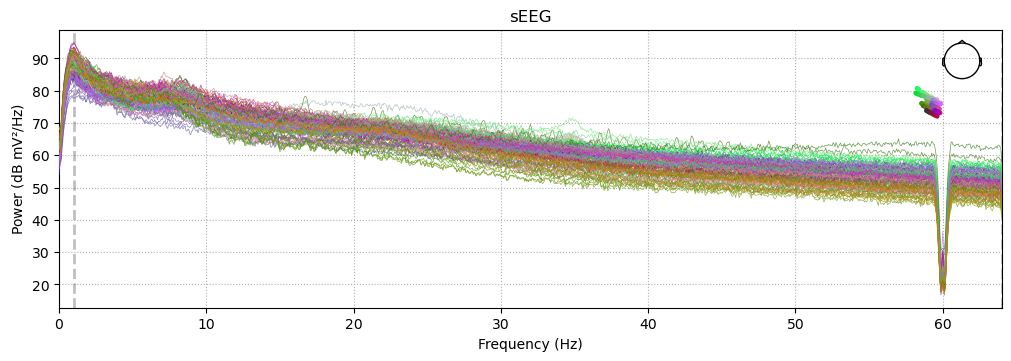

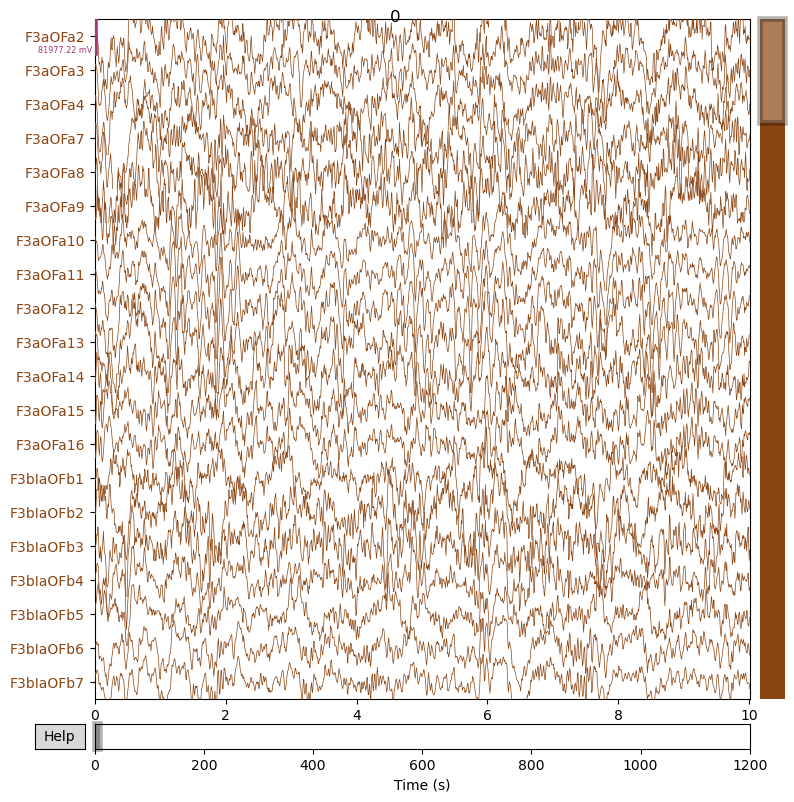

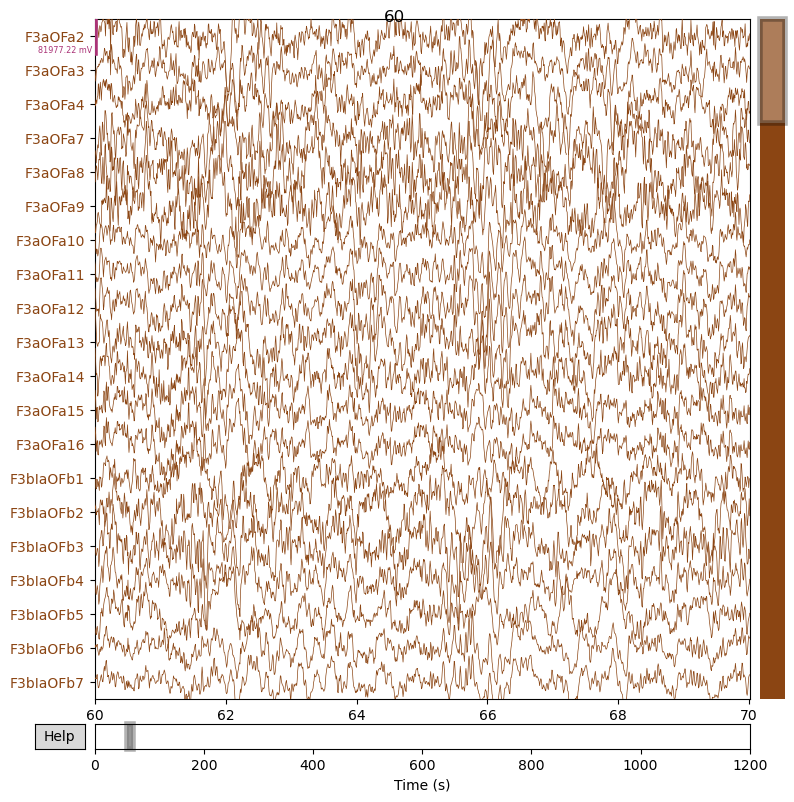

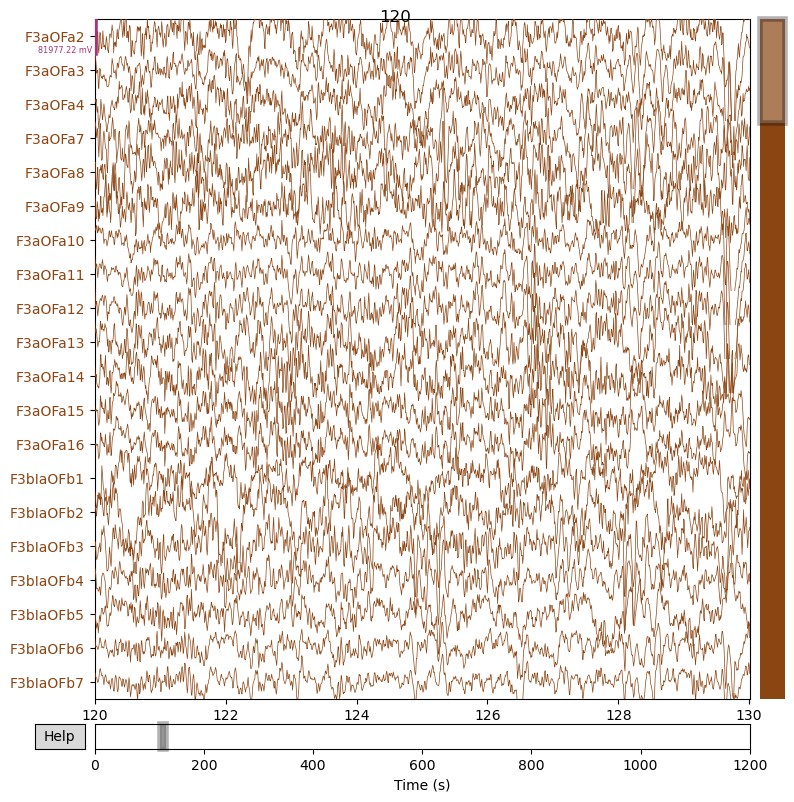

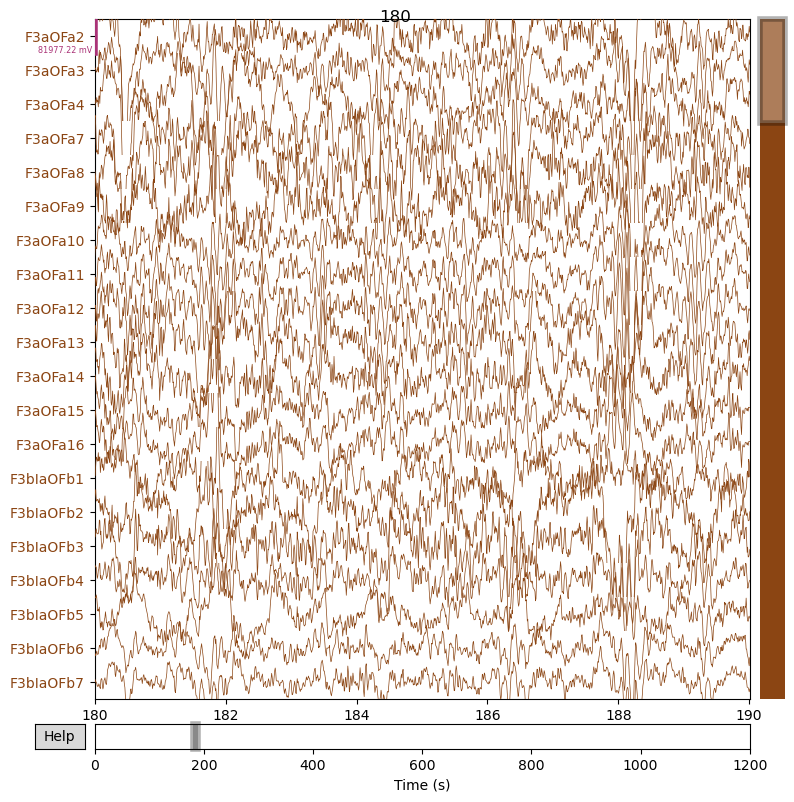

In [5]:
import matplotlib.pyplot as plt
# observe a peak in the theta or alpha bands
raw.compute_psd(fmax=sfreq/2).plot()
for start in np.arange(0, 200, 60):
    raw.plot(n_channels=20, scalings='auto', start=start, duration=10, show = False)
    plt.suptitle(start)
    plt.show()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.6s finished


Fitting ICA to data using 130 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.4s.
Creating RawArray with float64 data, n_channels=15, n_times=153600
    Range : 0 ... 153599 =      0.000 ...  1199.992 secs
Ready.


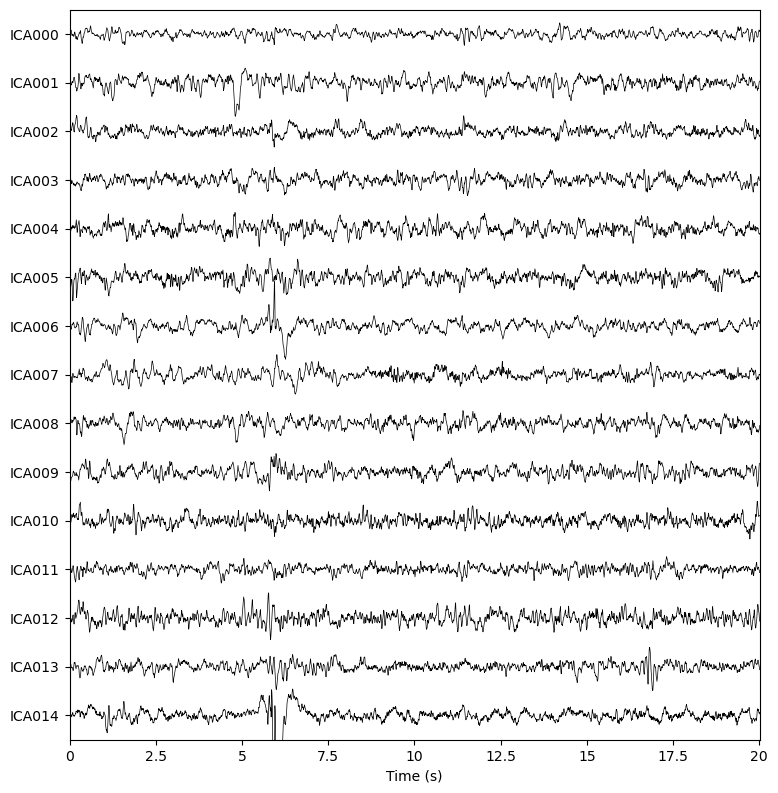

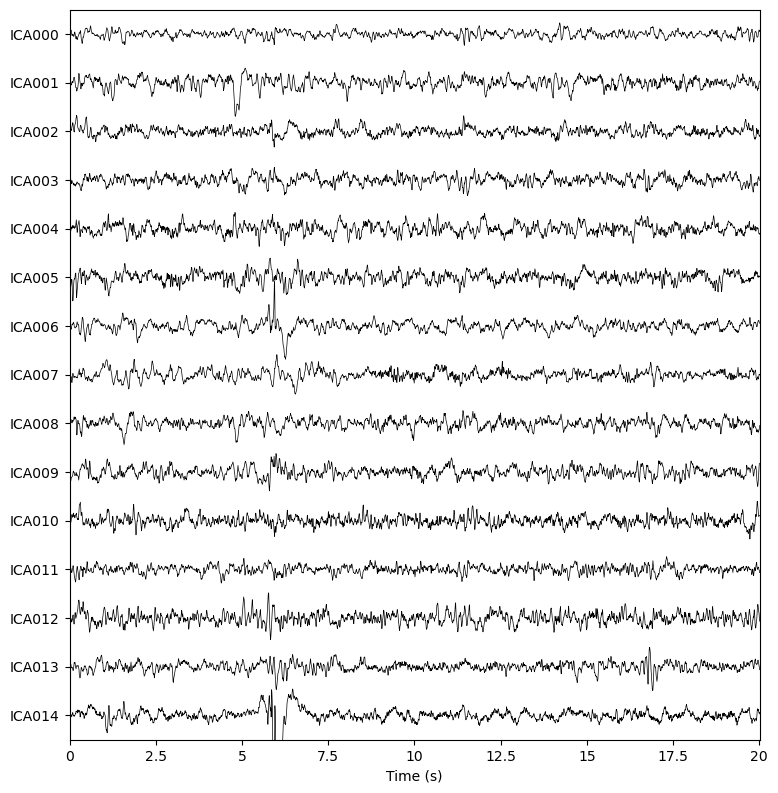

In [6]:
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)
ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica.plot_sources(raw, show_scrollbars=False)

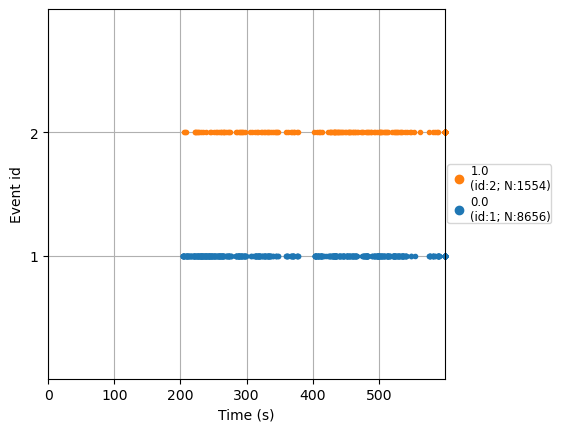

In [50]:
fig = mne.viz.plot_events(
    events, event_id=events_dict, sfreq=sfreq, first_samp=raw.first_samp
)

In [6]:
subjects_dict['words_df']

NameError: name 'subjects_dict' is not defined

In [125]:
epochs = mne.Epochs(raw, events, event_id=events_dict, 
                    tmin = -0.2, tmax = 0.6, baseline = (None, 0), 
                    event_repeated = 'drop')
#epochs.resample(new_sfreq)
epochs

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1071 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


<Epochs | 1071 events (good & bad), -0.203 – 0.602 s (baseline -0.203 – 0 s), ~147 KiB, data not loaded,
 '0.0': 906
 '1.0': 165>

Using data from preloaded Raw for 1071 events and 104 original time points ...
1 bad epochs dropped
Not setting metadata
1070 matching events found
No baseline correction applied
0 projection items activated


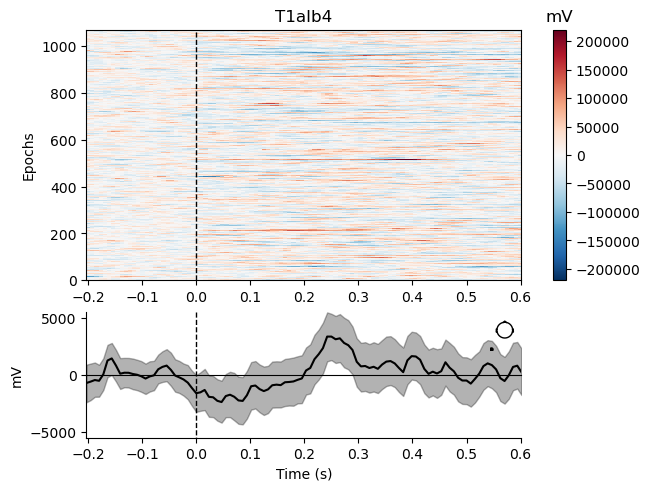

[<Figure size 640x480 with 4 Axes>]

In [8]:
electrode_info = subject.subject.electrode_info
electrodes = list(np.unique(electrode_info.Electrode[electrode_info.region_label == 'superiortemporal']))
epochs.plot_image(picks = electrodes[:1])

Using data from preloaded Raw for 924 events and 104 original time points ...
Using data from preloaded Raw for 20 events and 104 original time points ...


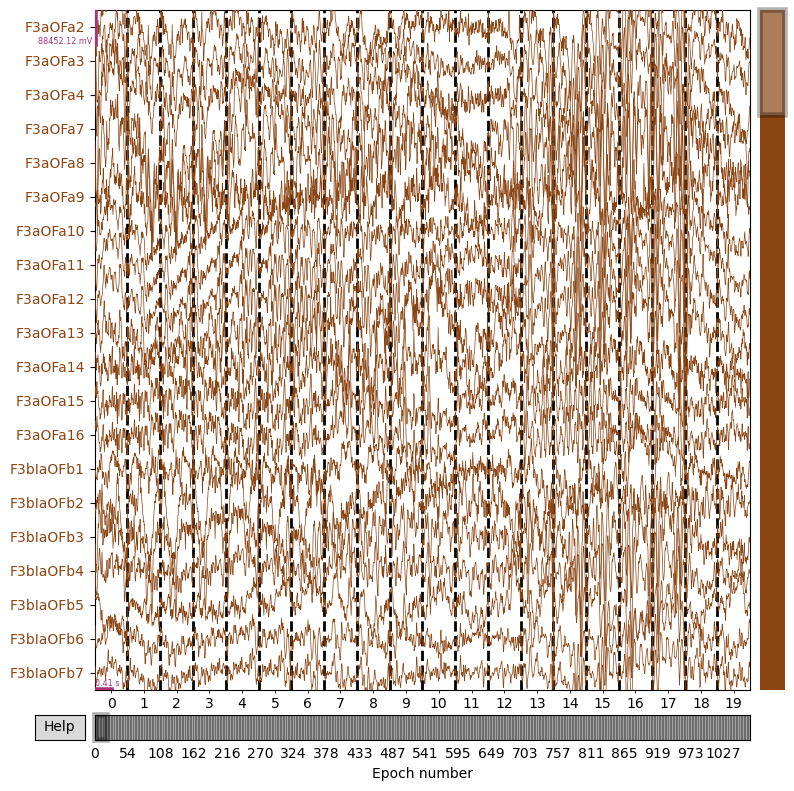

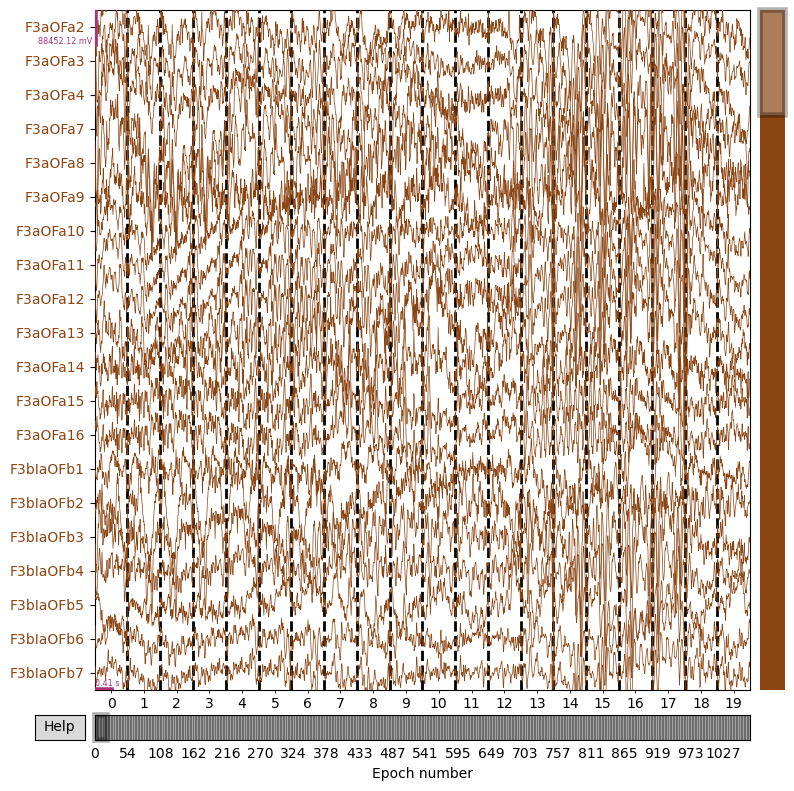

In [9]:
epochs.plot(scalings='auto', n_epochs=20, n_channels=20)


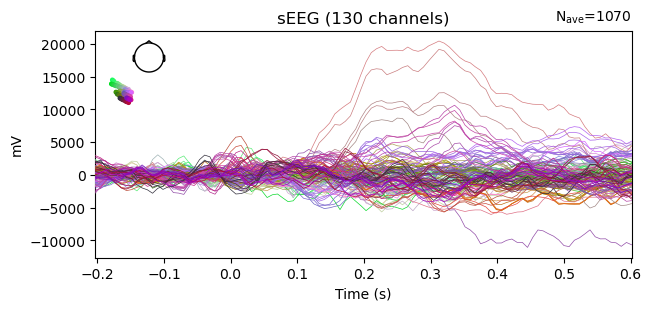

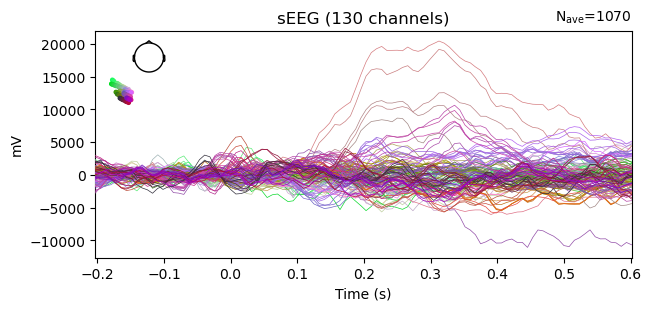

In [10]:
evoked = epochs.average()
evoked.plot()


Amygdala


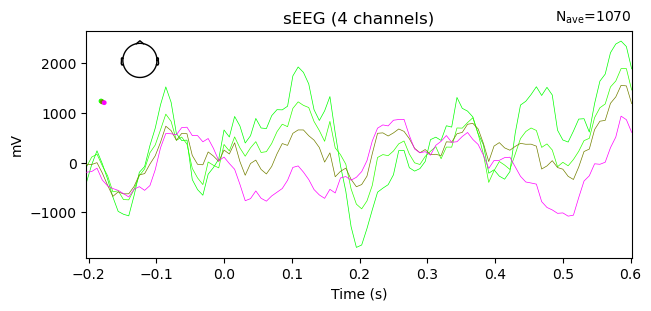

Hippocampus


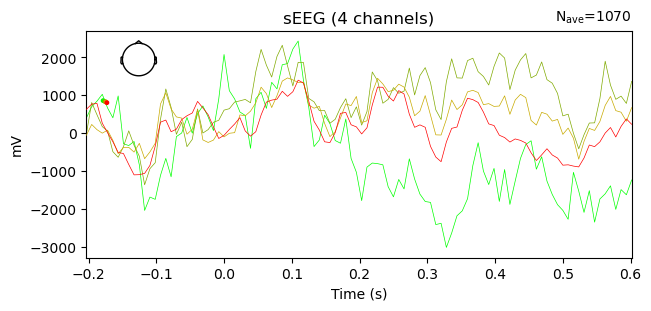

Unknown
Need more than one channel to make topography for seeg. Disabling interactivity.


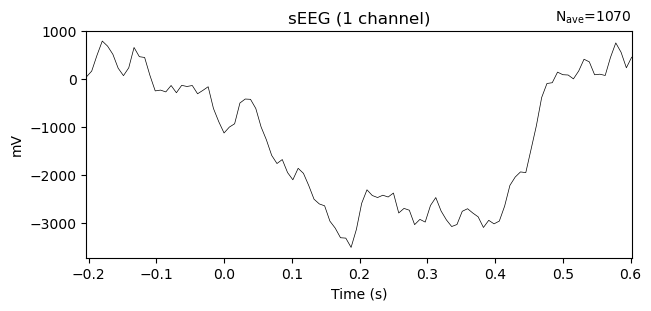

bankssts
Need more than one channel to make topography for seeg. Disabling interactivity.


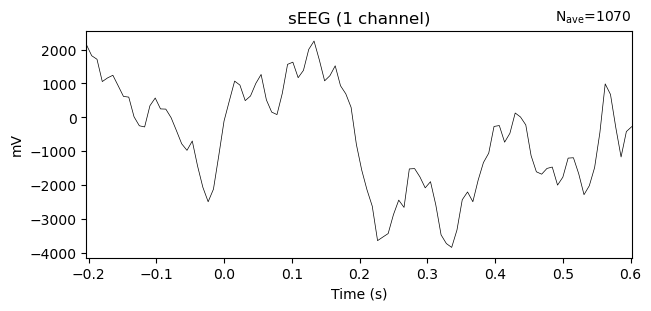

fusiform


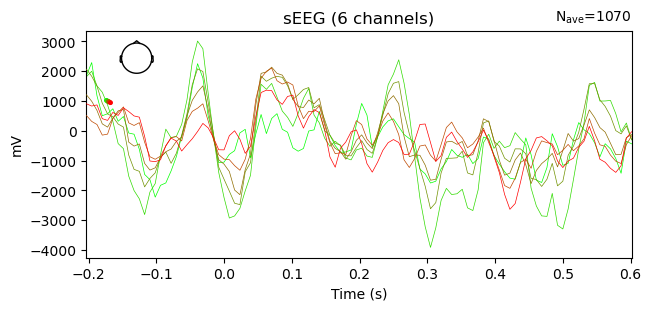

inferiorparietal


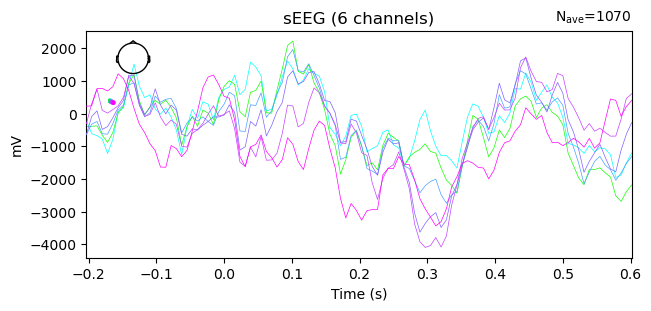

inferiortemporal


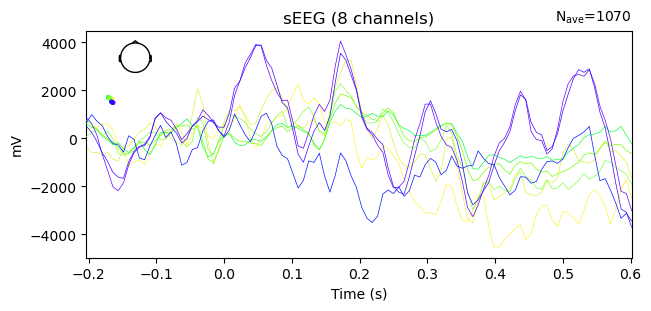

insula


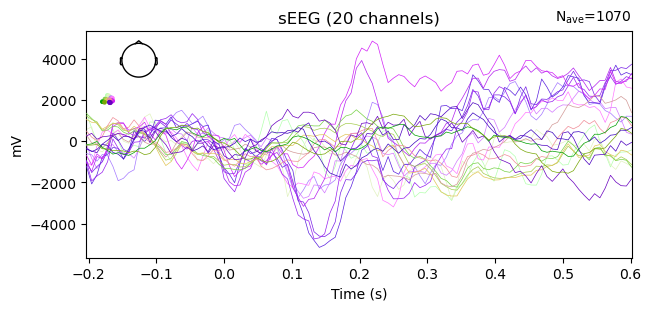

lateralorbitofrontal


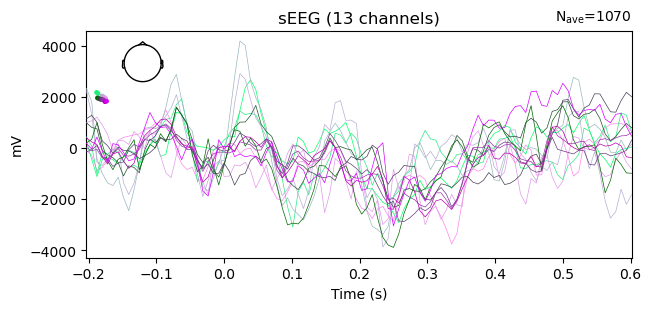

medialorbitofrontal


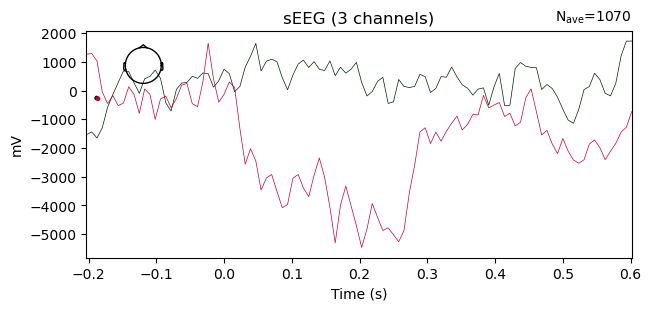

middletemporal


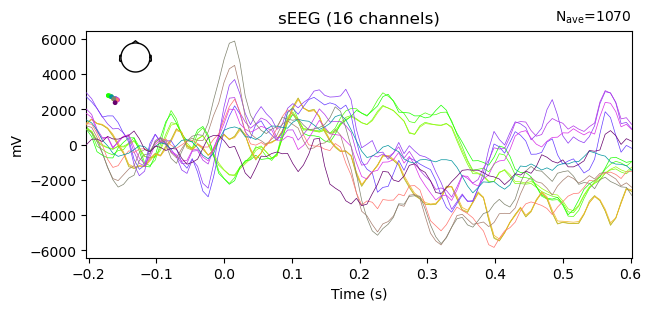

parsopercularis


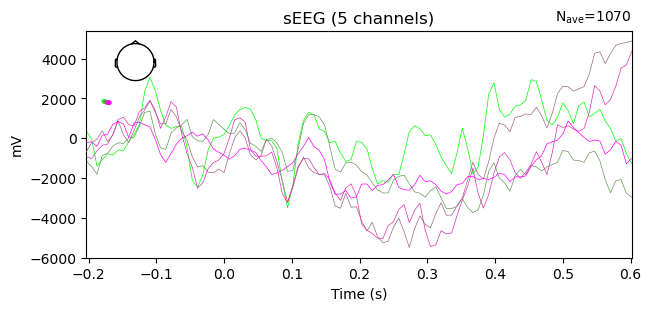

parstriangularis


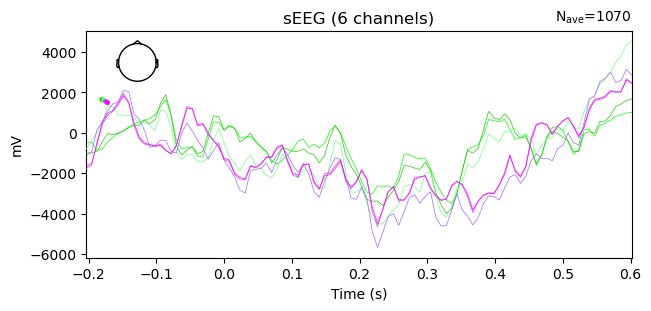

postcentral


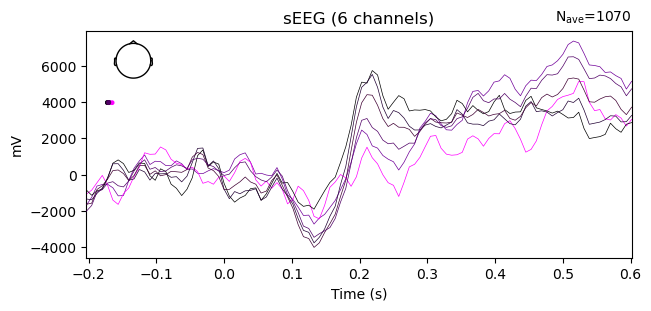

precentral


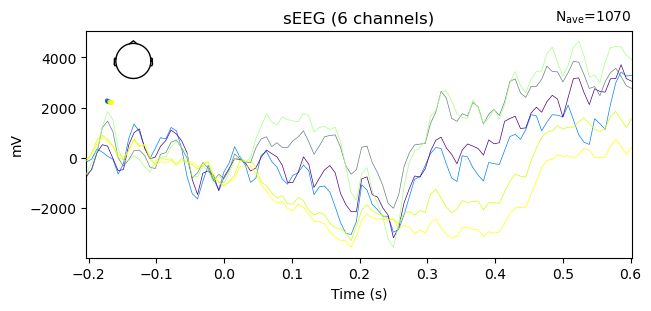

superiortemporal


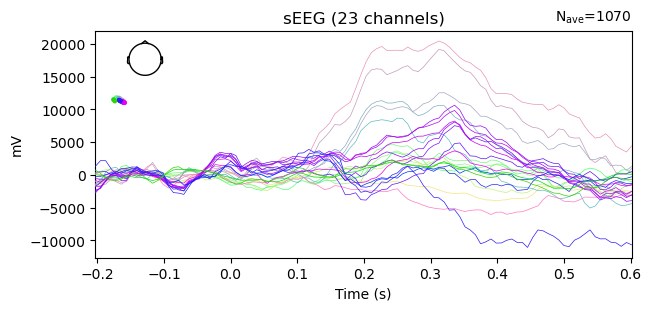

transversetemporal


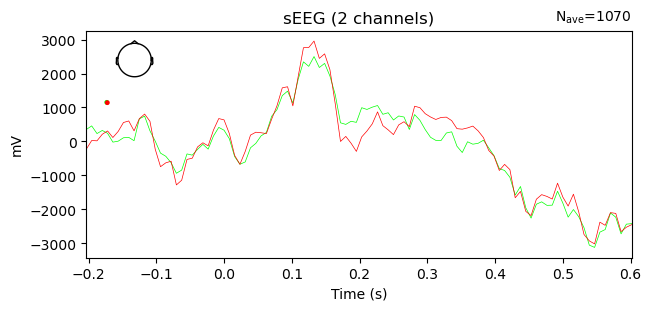

In [11]:
for region in np.unique(electrode_info.region_label):
    print(region)
    electrodes = list(np.unique(electrode_info.Electrode[electrode_info.region_label == region]))
    evoked.plot(picks = electrodes)
    plt.show()
    

In [126]:
X = epochs.get_data()  # shape (n_epochs, n_channels, n_times)
# Compute per-channel stats on the training set
means = X.mean(axis=(0, 2), keepdims=True)   # shape (1, n_ch, 1)
stds  = X.std(axis=(0, 2), keepdims=True)

# Z-score
X = (X - means) / (stds + 1e-6)

Y = epochs.events[:, -1]  # the event codes as target labels
print(X.shape, Y.shape)
#epochs.plot_drop_log()

Using data from preloaded Raw for 1071 events and 104 original time points ...
1 bad epochs dropped
(1070, 130, 104) (1070,)


In [ ]:
def get_subject_data(subject_id, trial_id, t_from, t_to, sfreq):
    subject = MNEBraintreebankSubject(subject_id=subject_id, allow_corrupted=False, cache=True)
    meta_dict, words_df, triggers = subject.get_trial_info(trial_id)
    events, events_dict = words_to_events(words_df, event_column = 'is_onset')

    raw = subject.get_trial_raw(trial_id, t_from = t_from, t_to = t_to)
    raw = preprocess(raw)
    raw, events = raw.resample(sfreq=sfreq, events = events)
    raw = raw.filter(l_freq=1.0, h_freq=None)
    epochs = mne.Epochs(raw, events, event_id=events_dict, 
                    tmin = -0.2, tmax = 0.6, baseline = (None, 0), 
                    event_repeated = 'drop')

    X = epochs.get_data()  # shape (n_epochs, n_channels, n_times)
    # Compute per-channel stats on the training set
    means = X.mean(axis=(0, 2), keepdims=True)   # shape (1, n_ch, 1)
    stds  = X.std(axis=(0, 2), keepdims=True)

    # Z-score
    X = (X - means) / (stds + 1e-6)
    
    Y = epochs.events[:, -1]  # the event codes as target labels
    return X, Y
    
import time
def elapsed(start):
    tdif = time.time() - start
    return tdif/60

# get all data for cars 2
subject_trial_pairs = [("10", 0), ("3", 0), ("7", 0)]
data_df = {
for subject_id, trial_id in subject_trial_pairs:
    start = time.time()
    X, Y = get_subject_data(subject_id, trial_id, t_from = 0, t_to = 1200, sfreq = 128)
    data_df[subject_id] = (X, Y)
    elapsed(start)

Movie name for the given subject and trial is: Fantastic Mr. Fox


In [138]:
import torch
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, X, Y, subject_id: str):
        self.data = X     # (n_trials, n_ch, n_time)
        self.labels = Y   # or whatever labels you need
        self.subject_id = subject_id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()  # (n_ch, n_time)
        y = int(self.labels[idx])
        # We return the subject ID string alongside each sample
        return x, y, self.subject_id

# Example: build a combined dataset for multiple subjects
datasets = [EEGDataset(X = X, Y = Y, subject_id = subject_id)]

from torch.utils.data import ConcatDataset
dataset = ConcatDataset(datasets)

# 2.1. collate_fn to handle variable channel counts
def collate_eeg(batch):
    """
    batch: list of tuples (x, y, subject_id)
     - x: Tensor(n_ch_i, seq_len)
    We stack along batch dim, and also collect subject_ids.
    """
    xs, ys, sids = zip(*batch)
    # Find max channels in this batch
    max_ch = max(x.shape[0] for x in xs)
    seq_len = xs[0].shape[1]
    padded = []
    for x in xs:
        ch = x.shape[0]
        if ch < max_ch:
            # pad channels with zeros so all tensors share same n_ch dimension
            pad = torch.zeros(max_ch - ch, seq_len)
            x = torch.cat([x, pad], dim=0)
        padded.append(x)
    x_batch = torch.stack(padded, dim=0)  # (batch, max_ch, seq_len)
    y_batch = torch.tensor(ys, dtype=torch.long)
    return x_batch, y_batch, list(sids)

batch_size= 256
loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_eeg
)


In [65]:
# subject.electrode_info

In [140]:
from model.GC_VASE import GC_VASE
# Usage:
n_trials, n_ch, seq_len = X.shape  # 1070, 130, 104
model = GC_VASE(seq_len=seq_len, latent_dim_s=32, latent_dim_r=32, 
                n_gcnn_layers = 0, edge_index=None).to(device)
print(model)
for sid, n_e in [(subject_id, n_ch)]: model.adaptive.add_subject(sid, n_e)

# recon, mus, lvs, mur, lvr = model(x, subject_ids)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_trainable_params(model)
print(f"Total trainable parameters: {total_params:,}")

GC_VASE(
  (adaptive): AdaptiveModuleManager(
    (encoders): ModuleDict()
    (decoders): ModuleDict()
  )
  (gcn_blocks): ModuleList()
  (trans_enc): ModuleList(
    (0-3): 4 x TransformerBlock(
      (layer): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (trans_dec): ModuleList(
    (0-3): 4 x TransformerBlock(
      (layer): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_pro

In [129]:
# ---- Loss functions ----
import torch
import torch.nn as nn
import torch.optim as optim
mse_loss = nn.MSELoss(reduction='mean')

# KL divergence for VAE
def kl_divergence(mu, logvar):
    # D_KL(N(mu, sigma) || N(0,1))
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Contrastive loss (NT-Xent)
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temp = temperature
        self.cos = nn.CosineSimilarity(dim=-1)

    def forward(self, z, labels):
        batch_size = z.size(0)
        sim_matrix = self.cos(z.unsqueeze(1), z.unsqueeze(0)) / self.temp
        mask = labels.unsqueeze(1) == labels.unsqueeze(0)
        mask.fill_diagonal_(False)
        positives = sim_matrix[mask].view(batch_size, -1)
        loss = -torch.log(
            torch.exp(positives).sum(dim=1) / torch.exp(sim_matrix).sum(dim=1)
        ).mean()
        return loss

contrastive_loss = NTXentLoss(temperature=0.5)



In [153]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 500
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---- Training loop ----
losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for x_batch, y, sids in loader:
        x_batch = x_batch.to(device)  # (batch, N_CH, SEQ_LEN)
        # Forward
        recon, mu_s, logvar_s, mu_r, logvar_r = model(x_batch, sids)
        # Reconstruction loss
        recon_loss = mse_loss(recon, x_batch)
        # KL losses
        kl_s = kl_divergence(mu_s, logvar_s) / (batch_size * seq_len)
        kl_r = kl_divergence(mu_r, logvar_r) / (batch_size * seq_len)
        # Contrastive loss using subject latent (mu_s)
        subj_labels = torch.tensor([int(sid) for sid in sids], device=device)
        cont = contrastive_loss(mu_s, subj_labels)

        # Total loss
        loss = recon_loss + kl_s + kl_r + cont

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    losses.append(avg_loss)
    print(f"Epoch {epoch:02d} | Avg Loss: {avg_loss:.4f}")

# After training, save model
torch.save(model.state_dict(), 'gc_vase_adaptive.pt')

Epoch 00 | Avg Loss: 6429.2362
Epoch 01 | Avg Loss: 10.7058
Epoch 02 | Avg Loss: 12.2422
Epoch 03 | Avg Loss: 12.9291
Epoch 04 | Avg Loss: 13.1034
Epoch 05 | Avg Loss: 12.3433
Epoch 06 | Avg Loss: 10.9744
Epoch 07 | Avg Loss: 9.4476
Epoch 08 | Avg Loss: 7.7758
Epoch 09 | Avg Loss: 5.8624
Epoch 10 | Avg Loss: 3.5936
Epoch 11 | Avg Loss: 2.2360
Epoch 12 | Avg Loss: 2.0010
Epoch 13 | Avg Loss: 1.8227
Epoch 14 | Avg Loss: 1.7388
Epoch 15 | Avg Loss: 1.5942
Epoch 16 | Avg Loss: 1.5259
Epoch 17 | Avg Loss: 1.4690
Epoch 18 | Avg Loss: 1.4584
Epoch 19 | Avg Loss: 1.3919
Epoch 20 | Avg Loss: 1.3440
Epoch 21 | Avg Loss: 1.2809
Epoch 22 | Avg Loss: 1.2168
Epoch 23 | Avg Loss: 1.2013
Epoch 24 | Avg Loss: 1.2032
Epoch 25 | Avg Loss: 1.1763
Epoch 26 | Avg Loss: 1.1622
Epoch 27 | Avg Loss: 1.1752
Epoch 28 | Avg Loss: 1.1443
Epoch 29 | Avg Loss: 1.1330
Epoch 30 | Avg Loss: 1.1343
Epoch 31 | Avg Loss: 1.1096
Epoch 32 | Avg Loss: 1.0975
Epoch 33 | Avg Loss: 1.0939
Epoch 34 | Avg Loss: 1.0927
Epoch 35 | 

In [159]:
def get_latents(model, x, sids, sample=False):
    """Returns (z_s, z_r) for inputs x, using either the posterior mean
       (sample=False) or a random draw (sample=True)."""
    model.eval()
    with torch.no_grad():
        _, mu_s, lv_s, mu_r, lv_r = model(x, sids)
        if sample:
            z_s = model.reparameterize(mu_s, lv_s)
            z_r = model.reparameterize(mu_r, lv_r)
        else:
            z_s, z_r = mu_s, mu_r
    return z_s, z_r

all_zs, all_zr = [], []
model.eval()
with torch.no_grad():
    for x_batch, y, sids in loader:
        z_s, z_r = get_latents(model, x_batch.to(device), sids, sample=False)
        all_zs.append(z_s.cpu())
        all_zr.append(z_r.cpu())
# concatenate back
Z_subject  = torch.cat(all_zs, dim=0)  # (N, latent_s)
Z_residual = torch.cat(all_zr, dim=0)  # (N, latent_r)

In [160]:
Z_subject.shape, Z_residual.shape

(torch.Size([1070, 32]), torch.Size([1070, 32]))

In [161]:
import umap

Z_dict = {
    'subject': Z_subject,
    'residual': Z_residual
}

embs = {}
for label, Z in Z_dict.items():
    emb = umap.UMAP(n_neighbors=20, random_state=42).fit_transform(Z)
    embs[label]=emb

/om2/group/fiete/loading/miniconda3/envs/mne/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/om2/group/fiete/loading/miniconda3/envs/mne/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/om2/group/fiete/loading/miniconda3/envs/mne/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/om2/group/fiete/loading/miniconda3/envs/mne/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


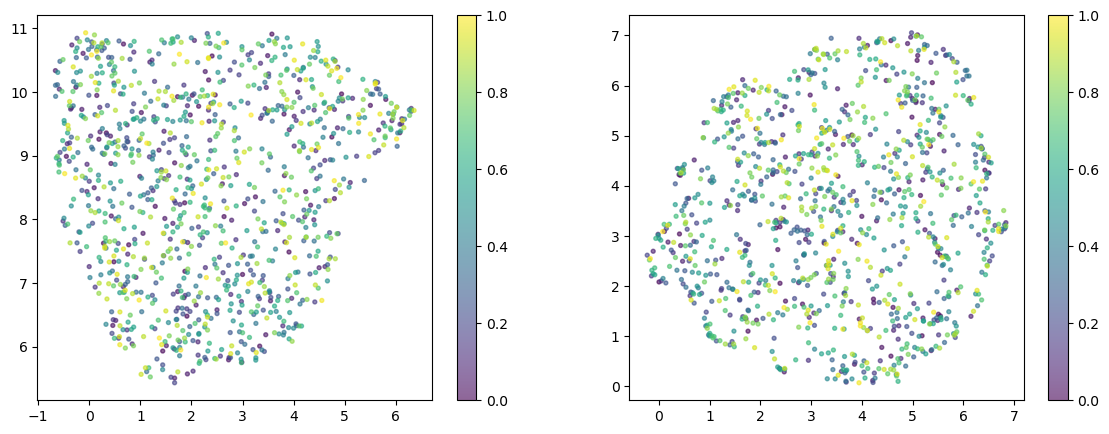

Text(0.5, 0.98, 'colored by time')

In [171]:
import matplotlib.pyplot as plt
t = np.arange(len(emb))
t = t/max(t)

cmap = plt.get_cmap('viridis')
fig, axes = plt.subplots(1, 2, figsize = (14, 5))
for i, emb in enumerate(embs.values()):
    sc = axes[i].scatter(emb[:, 0], emb[:, 1], s = 8, alpha = 0.6, c = cmap(t))
    plt.colorbar(sc, ax = axes[i])
plt.show()
plt.suptitle('colored by time')

In [70]:
x_batch.shape

torch.Size([256, 130, 104])